In [1]:
from transformers import BartTokenizer, BartForConditionalGeneration
import torch
from bertviz import model_view, head_view 

import matplotlib.pyplot as plt

from IPython.display import display, HTML

model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn", output_attentions=True)
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# ARTICLE_TO_SUMMARIZE = "Alternatively, you can generate multiple random sentences and try to fit them all into a single story. For instance, you could generate three sentences and use one to start your story; one for the midpoint; and one to finish off your final paragraph. Or if you want to mix things up even more, you can check out our Random Letter Generator tool, which you can use to generate different types of random writing prompts."
ARTICLE_TO_SUMMARIZE = "The complicated language in the huge new law has ruined the fight."

def bart_summarize(text, num_beams, length_penalty, max_length, min_length, no_repeat_ngram_size):
    text = text.replace('\n', '')
    text_input_ids = tokenizer.batch_encode_plus([text], return_tensors = 'pt', max_length=1024)['input_ids'].to(device)
    summary_ids = model.generate(text_input_ids, num_beams = int(num_beams), length_penalty = float(length_penalty), max_length = int(max_length), min_length=int(min_length), no_repeat_ngram_size = int(no_repeat_ngram_size)) 
    
    summary_txt = tokenizer.decode(summary_ids.squeeze(), skip_special_tokens = True)
    return summary_txt


def get_attention_tokens(text):
    inputs = tokenizer.encode(text, return_tensors = 'pt').to(device)
    outputs = model(inputs)
    attention = outputs[-1]
    cross_attention = outputs.cross_attentions
    encoder_attention = outputs.encoder_attentions
    decoder_attention = outputs.decoder_attentions
    tokens = tokenizer.convert_ids_to_tokens(inputs[0]) 
    
    return attention, encoder_attention, decoder_attention, cross_attention, tokens
 

attention, encoder_attention, decoder_attention, cross_attention, tokens = get_attention_tokens(ARTICLE_TO_SUMMARIZE)





In [2]:
bart_summarize(ARTICLE_TO_SUMMARIZE, 2, 1, 50, 1, 1)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


'The complicated language in the huge new law has ruined a fight. It\'s time to stop fighting and start living, says former MP David Mellor-Smith of Manchester City Council members who have been campaigning against it for months now: "'

In [3]:
model_view(attention, tokens)

<IPython.core.display.Javascript object>

In [4]:
head_view(attention, tokens)


<IPython.core.display.Javascript object>

- It seems that just like bart most words mainly give much attention to the delimiters
 

In [5]:
import numpy as np
np_att = torch.stack(list(attention), dim=0)

In [6]:
np_att.shape

torch.Size([12, 1, 16, 15, 15])

In [7]:
np_att = np.squeeze(np_att)

In [8]:
np_att.shape

torch.Size([12, 16, 15, 15])

In [9]:
new_arr = np.zeros((12,16,np_att.shape[-1]))

In [10]:
new_arr = np_att.max(3).values

In [11]:
new_arr.shape

torch.Size([12, 16, 15])

In [12]:
new_arr2 = new_arr.max(2).values

In [13]:
new_arr2.shape

torch.Size([12, 16])

In [14]:
import pandas as pd
np_new_arr2 = pd.DataFrame(new_arr2.detach().cpu(), index=[1,2,3,4,5,6,7,8,9,10,11,12], columns=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

In [15]:
np_new_arr2

1         2         3         4         5         6         7   \
1   0.615723  0.683875  0.985685  0.960597  0.832380  0.993769  0.887047   
2   0.992074  0.907817  0.948523  0.812405  0.958339  0.986413  0.916653   
3   0.952706  0.960928  0.944158  0.944311  0.951881  0.878951  0.953208   
4   0.962738  0.962500  0.991177  0.975796  0.983578  0.999978  0.984333   
5   0.996732  0.986519  0.990694  0.971124  0.981751  0.856824  0.974493   
6   0.966809  0.960937  0.967802  0.972526  0.950632  0.956553  0.969039   
7   0.934931  0.983747  0.999249  0.983232  0.982055  0.992979  0.954068   
8   0.921761  0.958873  0.868343  0.946701  0.929805  0.891088  0.889353   
9   0.554378  0.523488  0.492122  0.569695  0.610234  0.625007  0.664595   
10  0.712851  0.664513  0.798172  0.528171  0.870046  0.667437  0.701399   
11  0.904394  0.435493  0.711201  0.616675  0.568122  0.677411  0.734293   
12  0.955998  0.983690  0.906485  0.593189  0.775837  0.648904  0.857616   

          8         9         10        11        12        13        14  \
1   0.982663  0.679241  0.850859  0.908459  0.702677  0.749233  0.790800   
2   0.941339  0.904769  0.934959  0.942875  0.854757  0.834423  0.828173   
3   0.917846  0.960277  0.948193  0.880382  0.860677  0.894922  0.834571   
4   0.967571  0.986842  0.990926  0.999901  0.922003  0.996274  0.945431   
5   0.991484  0.992902  0.978360  0.985469  0.963104  0.946978  0.989816   
6   0.983897  0.975599  0.988684  0.988639  0.960308  0.959881  0.911959   
7   0.970808  0.981162  0.970836  0.954093  0.781956  0.970732  0.972192   
8   0.820592  0.971104  0.949394  0.963898  0.824187  0.976749  0.917831   
9   0.565224  0.507047  0.936055  0.658312  0.620965  0.535127  0.772447   
10  0.825706  0.745211  0.533071  0.792038  0.487331  0.728540  0.638052   
11  0.709201  0.754009  0.668225  0.657499  0.820596  0.602256  0.477337   
12  0.822784  0.512680  0.775341  0.673655  0.787238  0.978657  0.667717   

          15        16  
1   0.994196  0.761692  
2   0.911851  0.949957  
3   0.892521  0.923316  
4   0.967994  0.978272  
5   0.994457  0.976008  
6   0.970435  0.985913  
7   0.985380  0.934413  
8   0.884678  0.915555  
9   0.600977  0.737954  
10  0.733867  0.785141  
11  0.999817  0.455207  
12  0.931033  0.552952

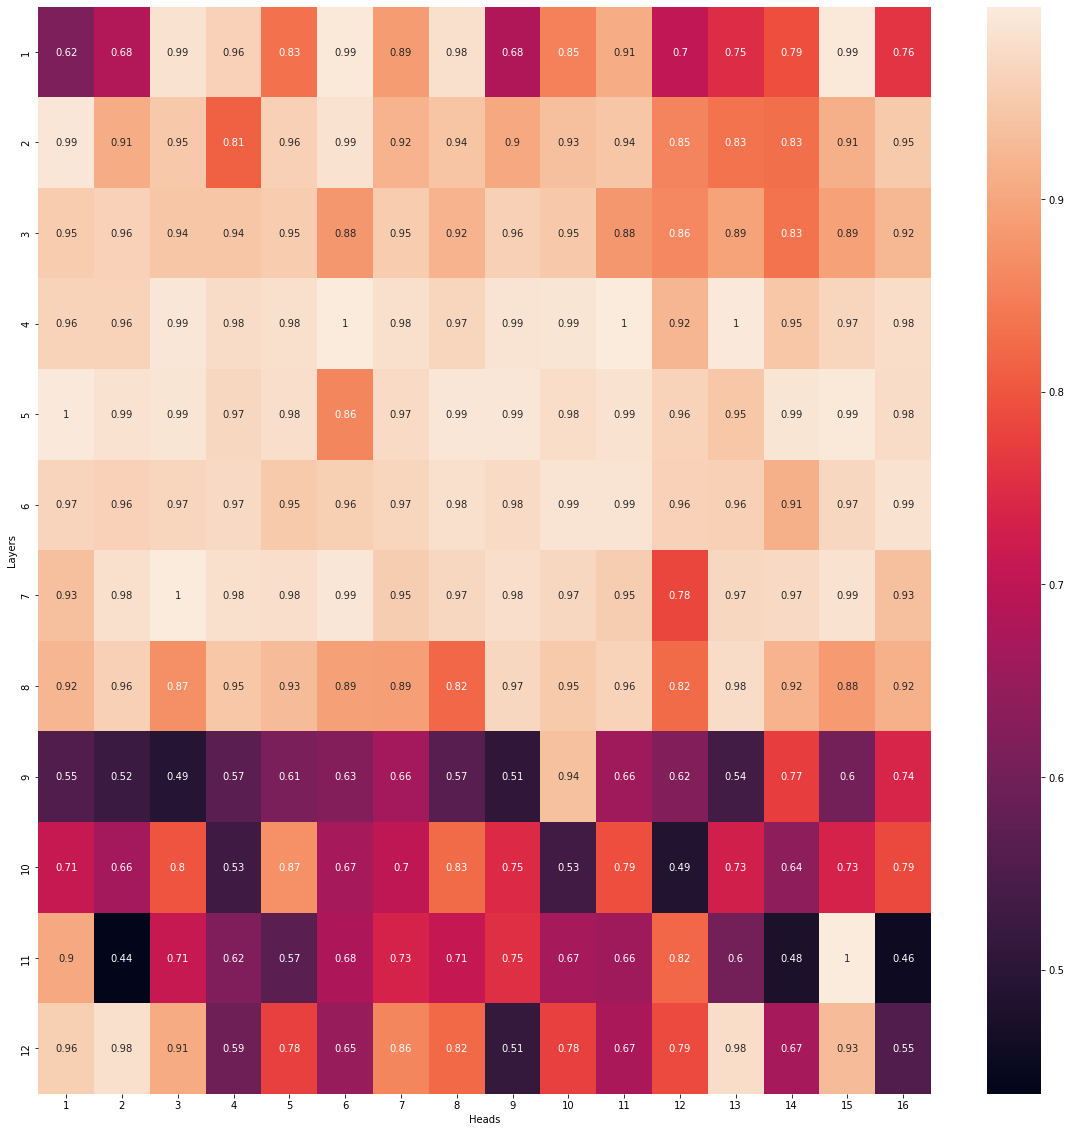

In [16]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
  
sn.heatmap(np_new_arr2, annot=True)
plt.ylabel("Layers")
plt.xlabel("Heads")
plt.show()

- The maximum attention seems to be higher in the layer from 2-8 and more defused in layers 9-12

In [85]:
ARTICLE_TO_SUMMARIZE = "I am a person. I eat meat everyday. I like to run and exercise."
bart_summarize(ARTICLE_TO_SUMMARIZE, 2, 1, 40, 1, 1)

'I eat meat everyday. I like to run and exercise, says the mother of two who has been in a coma for three weeks after suffering from an apparent heart attack last month; she'

In [86]:
def get_encode_decode_attention_tokens(text):
    inputs = tokenizer.encode(text, return_tensors = 'pt').to(device)
    outputs = model(inputs)
    encoder_attention=outputs.encoder_attentions,
    attention = outputs[-1]
    decoder_attention=outputs.decoder_attentions,
    tokens = tokenizer.convert_ids_to_tokens(inputs[0]) 
    
    return encoder_attention, decoder_attention, attention, tokens

In [87]:
encoder_attention, decoder_attention, attention2, tokens2 = get_encode_decode_attention_tokens(ARTICLE_TO_SUMMARIZE)

In [88]:
 for i  in encoder_attention:
    np_en_att = torch.stack(list(i), dim=0)

In [89]:
np_en_att = np_en_att.squeeze(1)
np_en_att.shape

torch.Size([12, 16, 19, 19])

In [90]:
en_att_idx1 = torch.argmax(np_en_att, axis = 3)

In [91]:
en_att_idx1.shape

torch.Size([12, 16, 19])

In [92]:
new_arr = np.zeros((12,16))

In [93]:
for idx, i in enumerate(en_att_idx1[:,:]):
    for idj, j in enumerate(i):
        for idk, k in enumerate(j):
            if k == (idk-1) or k == (idk +1):
                new_arr[idx, idj] = new_arr[idx, idj] + 1

In [94]:
new_arr

array([[ 2.,  1.,  0., 15.,  1.,  1.,  6.,  0.,  2., 13.,  1.,  2.,  0.,
         2., 12.,  2.],
       [ 1.,  1.,  8.,  1.,  3.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.],
       [ 2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  4.,  1.,  1.,  0.,
         1.,  1.,  1.],
       [ 1.,  1.,  1.,  0.,  1., 18.,  1.,  1.,  1.,  3.,  1.,  1.,  1.,
        15.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1., 12.,
         2.,  1.,  7.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  4.,  1.],
       [ 1.,  1.,  2.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.],
       [ 1.,  4.,  1.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,
         1.,  1.,  1.],
       [ 1.,  3.,  2.,  1.,  2.,  2.,  2.,  2.,  1.,  9.,  1.,  2.,  6.,
         3.,  2.,  1.],
       [ 2.,  2.,  2.,  3.,  3.,  4.,  2.,  3.,  2.,  4.,  3.,  3.,  2.,
         3.,  2.,  3.],
       [ 2.,  1.,  1.,  2.,  2

 ## Encoder Attention Relative Positioning

In [95]:
import torch.nn as nn
m = nn.Softmax(dim=1)
 
output_m = m(torch.from_numpy(new_arr))

In [96]:
row_sums = new_arr.sum(axis=1)
new_matrix = new_arr / row_sums[:, np.newaxis]

In [97]:
new_matrix.shape

(12, 16)

In [98]:
import pandas as pd
new_pd = pd.DataFrame(new_matrix, index=[1,2,3,4,5,6,7,8,9,10,11,12], columns=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

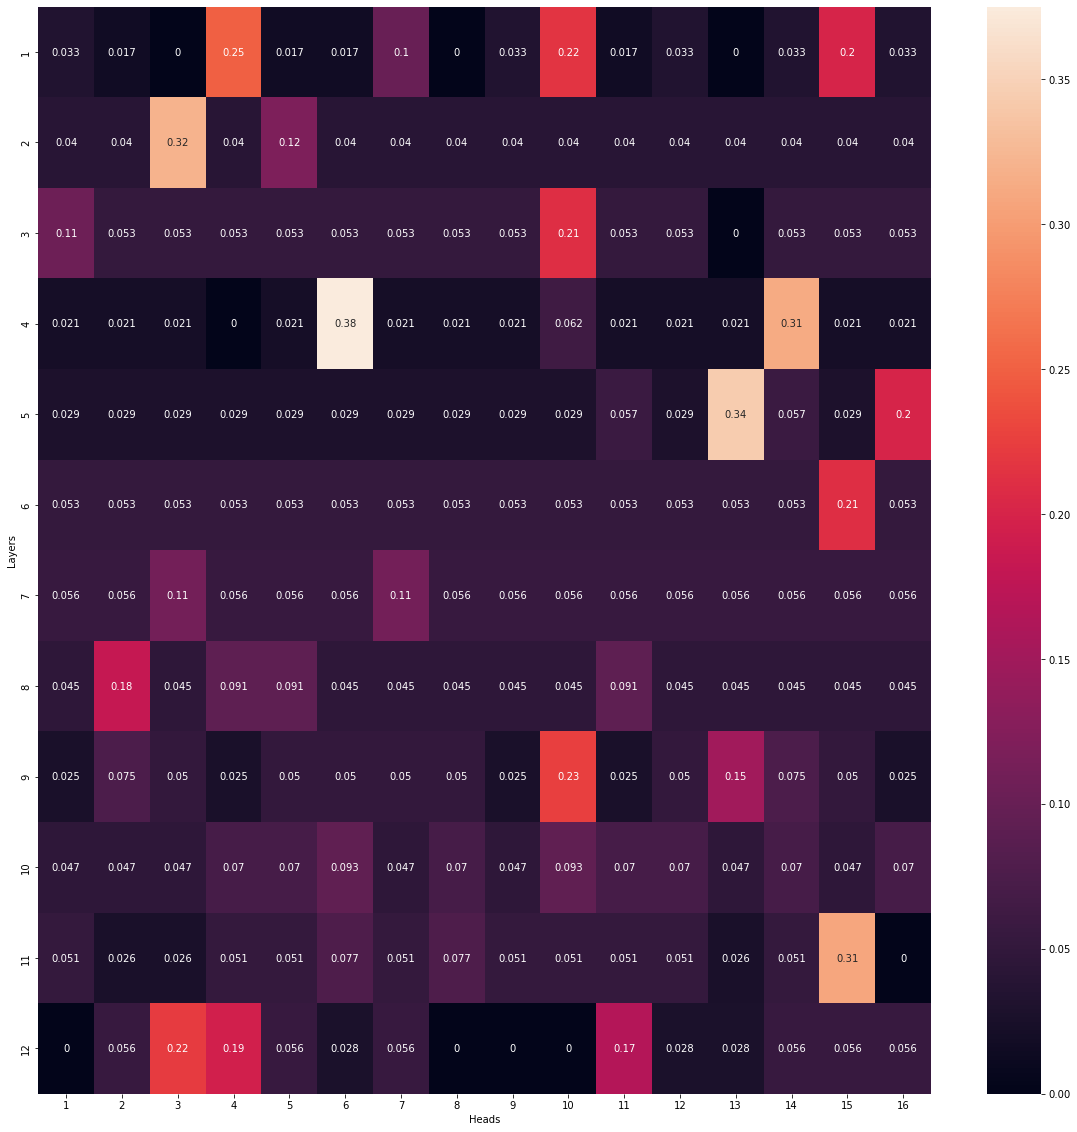

In [99]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))

sn.heatmap(new_pd, annot=True)
plt.ylabel("Layers")
plt.xlabel("Heads")
plt.show()

 ## Decoder Attention Relative Positioning

In [100]:
 for i  in decoder_attention:
    np_de_att = torch.stack(list(i), dim=0)

In [101]:
np_de_att = np_de_att.squeeze(1)
np_de_att.shape

torch.Size([12, 16, 19, 19])

In [102]:
de_att_idx1 = torch.argmax(np_de_att, axis = 3)

In [103]:
new_arr_de = np.zeros((12,16))

In [104]:
for idx, i in enumerate(de_att_idx1[:,:]):
    for idj, j in enumerate(i):
        for idk, k in enumerate(j):
            if k == (idk-1) or k == (idk +1):
                new_arr_de[idx, idj] = new_arr_de[idx, idj] + 1
  

In [105]:
new_arr_de

array([[18., 14.,  2.,  2., 13.,  0.,  2.,  4.,  3.,  0.,  3.,  1.,  2.,
         4.,  1.,  8.],
       [ 6.,  1.,  1.,  1.,  5.,  2.,  1., 16., 15.,  0.,  2.,  1.,  3.,
         1.,  2.,  1.],
       [ 0., 15.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,
         3.,  1.,  1.],
       [ 2.,  3.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  7.,  7.,  2.,  0.,
         1.,  2.,  2.],
       [ 0.,  2.,  0.,  0.,  1.,  2.,  1.,  1.,  1.,  1.,  2.,  0.,  4.,
         1.,  2.,  1.],
       [ 1.,  2.,  1.,  1.,  2.,  0.,  2.,  1.,  2.,  2.,  4.,  3.,  1.,
         1.,  2.,  2.],
       [ 2.,  0.,  0.,  1.,  1.,  1.,  2.,  1.,  5., 13.,  0.,  1.,  0.,
         1.,  1.,  1.],
       [ 1.,  0.,  6.,  3.,  1.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,
         2.,  1.,  1.],
       [ 1.,  4.,  2.,  1.,  1.,  1.,  1.,  4.,  4.,  0.,  1.,  1.,  0.,
        15.,  1.,  1.],
       [ 5.,  1.,  1.,  1.,  1.,  0.,  2.,  1.,  1.,  1.,  6.,  2.,  1.,
         1., 12.,  1.],
       [ 0.,  1.,  0.,  1.,  0

In [106]:
row_sums2 = new_arr_de.sum(axis=1)
new_matrix2 = new_arr_de / row_sums2[:, np.newaxis]

import pandas as pd
new_pd = pd.DataFrame(new_matrix2, index=[1,2,3,4,5,6,7,8,9,10,11,12], columns=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

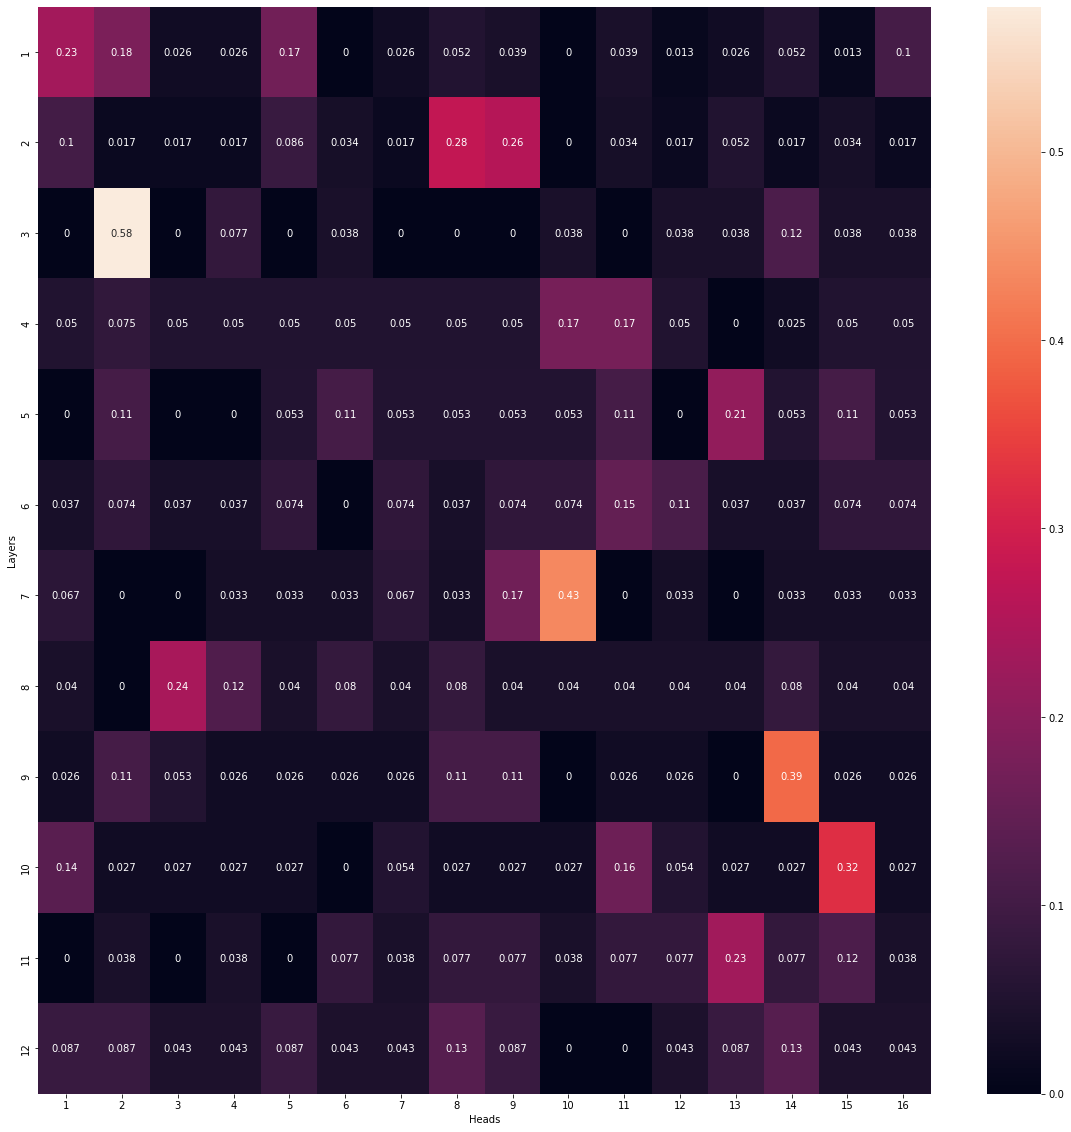

In [107]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
  
sn.heatmap(new_pd, annot=True)
plt.ylabel("Layers")
plt.xlabel("Heads")
plt.show()

- There are not many maxium attention in relative positioning so maybe there is not much inductive bias in BART

In [108]:
np_en_att.shape

torch.Size([12, 16, 19, 19])

In [109]:
de_new_arr = np.zeros((12,16,np_en_att.shape[-1]))
de_new_arr = np_en_att.max(3).values
de_new_arr2 = de_new_arr.max(2).values
de_new_arr2 = pd.DataFrame(de_new_arr2.detach().cpu(), index=[1,2,3,4,5,6,7,8,9,10,11,12], columns=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

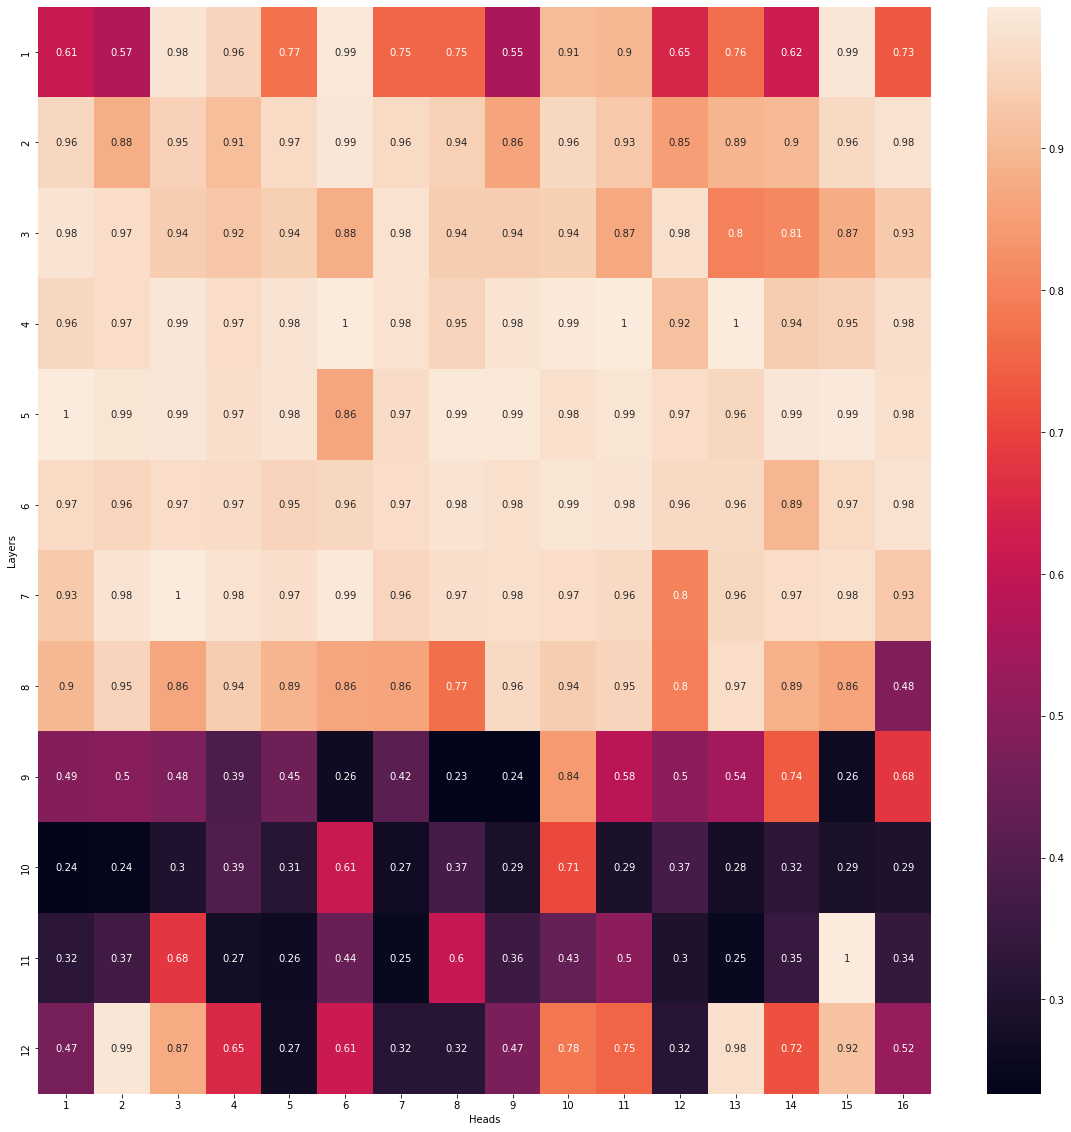

In [110]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
  
sn.heatmap(de_new_arr2, annot=True)
plt.ylabel("Layers")
plt.xlabel("Heads")
plt.show()